In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re

In [37]:
DATA_DIR = Path("../new_data/datasets_circle_preproc")  
PATTERN   = "dataset_raw*.csv"            

names = ["t", "ax", "ay", "yawRate", "steer", "gas"]

def natural_key(p):                
    parts = re.split(r"(\d+)", p.stem)
    return [int(s) if s.isdigit() else s for s in parts]

dfs_circle = []
for f in sorted(DATA_DIR.glob(PATTERN), key=natural_key):
    df = pd.read_csv(
        f,
        engine="python"
    )
    dfs_circle.append(df[1:])

In [38]:
len(dfs_circle), dfs_circle[0]

(60,
           t      ax      ay   yawRate   steer     gas
 1    1767.0 -0.0645  0.0006    1.9512  3224.0  3600.0
 2    1946.0 -0.0253  0.0321   -0.4268  3540.0  2922.0
 3    2666.0 -0.0480 -0.0012    0.0915  2984.0  2874.0
 4    3386.0 -0.0499  0.0268   -0.1220  3770.0  2886.0
 5    4106.0 -0.0639 -0.0111    0.0915  3078.0  3028.0
 6    4826.0 -0.0664  0.0194   -0.3049  3272.0  3460.0
 7    5545.0 -0.0474  0.0404   -0.2134  3568.0  3660.0
 8    6248.0 -0.0336  0.0644   -0.1220  3706.0  3982.0
 9    6607.0 -0.4937 -0.6208   72.9268  3706.0  3988.0
 10   6788.0 -0.4745 -3.1374  109.3598  3776.0  3988.0
 11   6968.0 -0.9571 -4.0245  150.9451  3846.0  4002.0
 12   7507.0 -1.1631 -4.1170  283.2927  4002.0  4002.0
 13   7688.0 -4.0291 -5.3282  318.1708  4002.0  4002.0
 14   7867.0 -4.5482 -4.3425  299.6037  4002.0  4002.0
 15   8047.0 -4.1428 -3.7790  260.8537  4004.0  4002.0
 16   8227.0 -3.6279 -4.9022  238.3232  4004.0  4002.0
 17   8587.0 -3.3562 -4.9273  273.5671  4004.0  4002.0
 18  

In [39]:
def plot_data(df):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    # угловое ускорение
    axs[0].plot(df["t_sec"], df["angular_accel"], color='tab:red')
    axs[0].set_title("Angular Acceleration")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Angular Accel (deg/s²)")
    axs[0].grid(True)

    # траектория
    axs[1].plot(df["x_world"], df["y_world"], color='tab:blue')
    axs[1].set_title("Trajectory (World Frame)")
    axs[1].set_xlabel("X (m)")
    axs[1].set_ylabel("Y (m)")
    axs[1].axis('equal')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

In [47]:
import numpy as np
import pandas as pd

def data_to_world_frame(df):
    df = df.copy()
    
    # Time in seconds
    df["t_sec"] = df["t"] / 1000
    dt = df["t_sec"].diff().fillna(0.02).astype(float)  # Default 20ms if NaN

    # Initialize yaw integration
    yaw = np.zeros(len(df))
    yaw_rate = df["yawRate"].values
    for i in range(1, len(df)):
        yaw[i] = yaw[i-1] + yaw_rate[i] * dt.iloc[i]
    df["yaw"] = yaw
    df["yaw_rad"] = np.deg2rad(df["yaw"])

    # Vectorized rotation to world frame
    theta = df["yaw_rad"].values
    ax = df["ax"].values
    ay = df["ay"].values
    
    df["ax_world"] = ax * np.cos(theta) - ay * np.sin(theta)
    df["ay_world"] = ax * np.sin(theta) + ay * np.cos(theta)

    # Angular acceleration
    df["angular_accel"] = df["yawRate"].diff() / dt
    df["angular_accel"] = df["angular_accel"].fillna(0).astype(float)

    # Initialize trajectory integration arrays
    vx = np.zeros(len(df))
    vy = np.zeros(len(df))
    x = np.zeros(len(df))
    y = np.zeros(len(df))
    
    ax_world = df["ax_world"].values
    ay_world = df["ay_world"].values
    
    for i in range(1, len(df)):
        dt_i = dt.iloc[i]
        vx[i] = vx[i-1] + ax_world[i] * dt_i
        vy[i] = vy[i-1] + ay_world[i] * dt_i
        x[i] = x[i-1] + vx[i] * dt_i
        y[i] = y[i-1] + vy[i] * dt_i
    
    df["x_world"] = x
    df["y_world"] = y

    return df

In [48]:
!mkdir -p ../new_data/datasets_circle_all

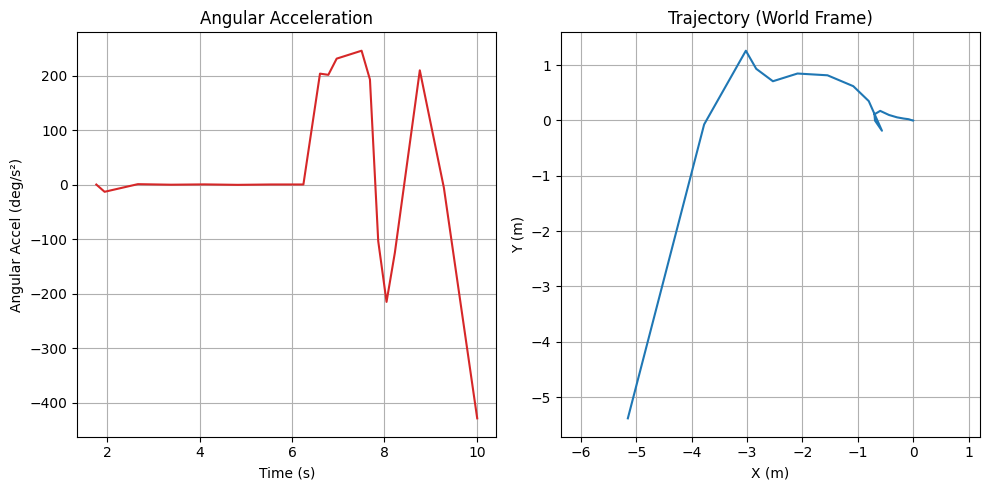

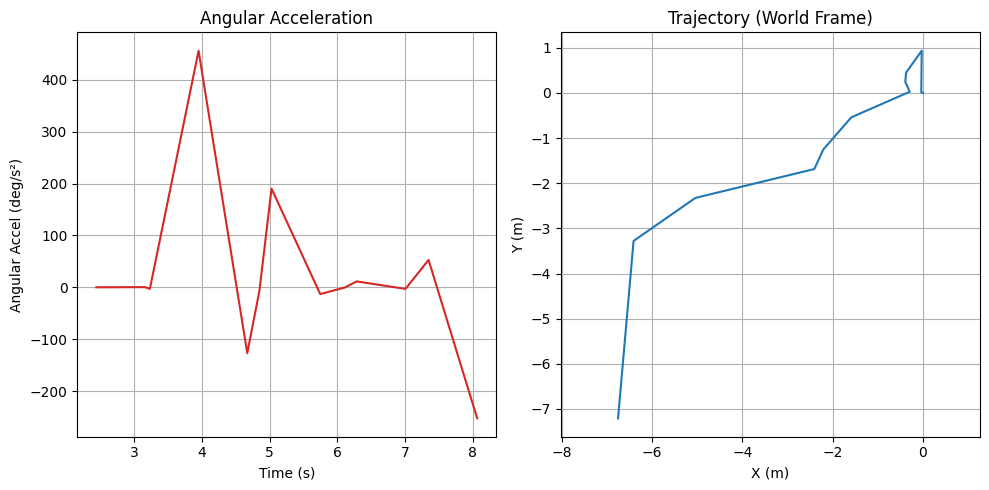

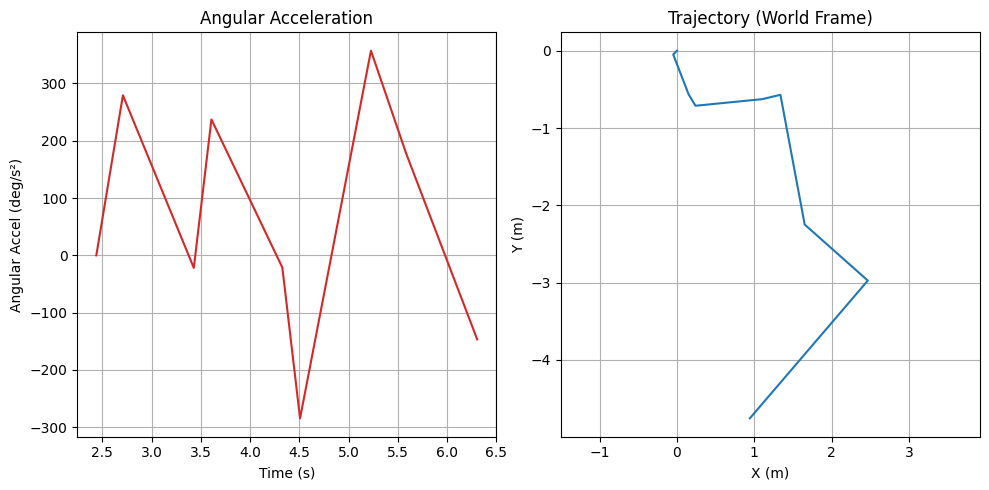

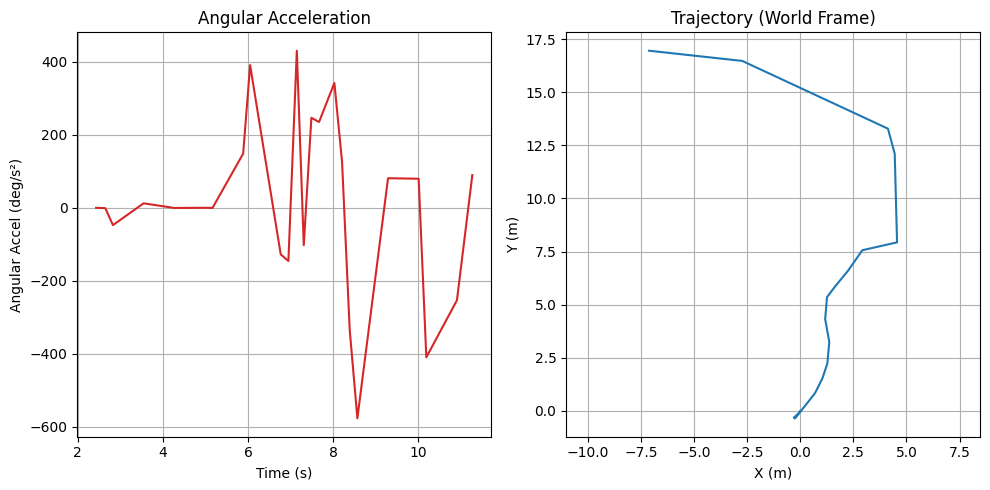

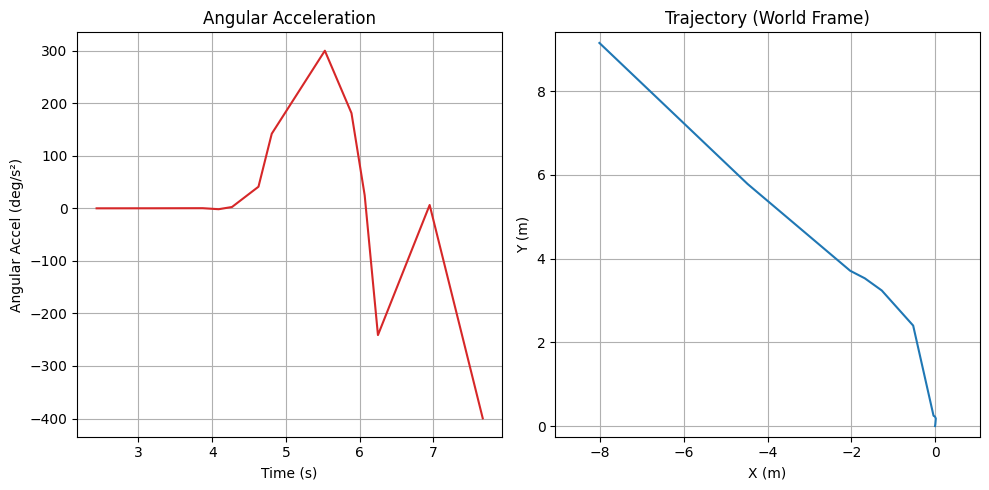

In [49]:
n = 1
for df_i in dfs_circle:
    df_new = data_to_world_frame(df_i)
    df_new.to_csv(f'../new_data/datasets_circle_all/dataset_raw{n}.csv', index=False)
    if n <= 5:
        plot_data(df_new)
    n += 1